# ARTIFICIAL INTELLIGENCE PROJECT
## Santello Veronica 870320

# Recognition and classification of road signs

In [36]:
import torch
print(torch.__version__)

1.9.1


## CNN

### Load data

In [37]:
import csv 
import xml.etree.ElementTree as ET
import os
import numpy as np

path = r"C:\Users\VERONICA\Desktop\PROGETTO PELILLO\annotations"
filenames = []
tmp = []
tmp1 = []


for filename in os.listdir(path):
    if not filename.endswith('.xml'):
        continue
    fullname = os.path.join(path,filename)
    filenames.append(fullname)
    
    
for filename in filenames:
    tree = ET.parse(filename)
    root = tree.getroot()
    
    for datir in root.iter('annotation'):
        objects = []
        
        for name in datir.iter('filename'):
            tmp1.append(name.text)

        for element in datir.iter('object'):
            for name in element.iter('name'):
                objects.append(name.text)
               
        tmp = tmp + [objects]

                    
labels = np.array(tmp, dtype=object)   
names = np.array(tmp1)
                

In [38]:
#Load libraries
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [39]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)

In [40]:
#resize all the images with the same size
#flip the image with probability 0.5
#converts numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
#normalize data from [0,1] to [-1,1] 

transformer =   transforms.Compose([
                transforms.Resize((150,150)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),  
                transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] with formula (x - mean)/std
                                    [0.5,0.5,0.5])
])

In [41]:
#Path for training and testing directory
path = 'C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images/'
train_path='C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images/training_set'
test_path='C:/Users/VERONICA/Desktop/PROGETTO PELILLO/images/test_set'


train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['crosswalk', 'speedlimit', 'stop', 'trafficlight']


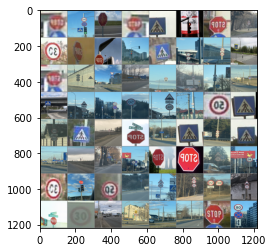

 stop crosswalk  stop  stop crosswalk trafficlight  stop speedlimit speedlimit  stop  stop crosswalk crosswalk speedlimit speedlimit crosswalk  stop speedlimit crosswalk speedlimit speedlimit speedlimit speedlimit speedlimit crosswalk speedlimit speedlimit speedlimit speedlimit speedlimit speedlimit crosswalk speedlimit crosswalk speedlimit  stop speedlimit crosswalk speedlimit crosswalk speedlimit speedlimit speedlimit speedlimit  stop  stop speedlimit speedlimit speedlimit  stop speedlimit speedlimit crosswalk speedlimit speedlimit speedlimit  stop speedlimit trafficlight speedlimit speedlimit speedlimit  stop


In [86]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(63)))

In [42]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1    f kernel size = 3, w = 150
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output

In [43]:
model=ConvNet(num_classes=4).to(device)

In [44]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
num_epochs=10

In [45]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
test_count=len(glob.glob(test_path+'/**/*.png'))

print(train_count,test_count)

747 432


In [46]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(18.5951) Train Accuracy: 0.5957161981258366 Test Accuracy: 0.5555555555555556
Epoch: 1 Train Loss: tensor(5.6115) Train Accuracy: 0.6947791164658634 Test Accuracy: 0.6875
Epoch: 2 Train Loss: tensor(2.2421) Train Accuracy: 0.8085676037483266 Test Accuracy: 0.6921296296296297
Epoch: 3 Train Loss: tensor(1.6789) Train Accuracy: 0.8527443105756358 Test Accuracy: 0.6597222222222222
Epoch: 4 Train Loss: tensor(1.3465) Train Accuracy: 0.8674698795180723 Test Accuracy: 0.6481481481481481
Epoch: 5 Train Loss: tensor(1.3327) Train Accuracy: 0.8808567603748326 Test Accuracy: 0.7106481481481481
Epoch: 6 Train Loss: tensor(1.2688) Train Accuracy: 0.8755020080321285 Test Accuracy: 0.5555555555555556
Epoch: 7 Train Loss: tensor(1.2563) Train Accuracy: 0.927710843373494 Test Accuracy: 0.6990740740740741
Epoch: 8 Train Loss: tensor(1.2761) Train Accuracy: 0.9022757697456493 Test Accuracy: 0.7222222222222222
Epoch: 9 Train Loss: tensor(1.3858) Train Accuracy: 0.9196787148594

In [59]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

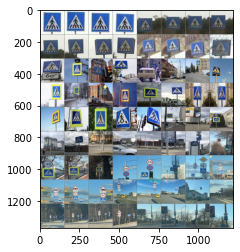

GroundTruth:  crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk crosswalk


In [81]:
import matplotlib.pyplot as plt

testset =  torchvision.datasets.ImageFolder(test_path,transform=transformer)
testloader = torch.utils.data.DataLoader(testset, batch_size=72,
                                         shuffle=False, num_workers=4)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(72)))